## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

## And so on and so forth...

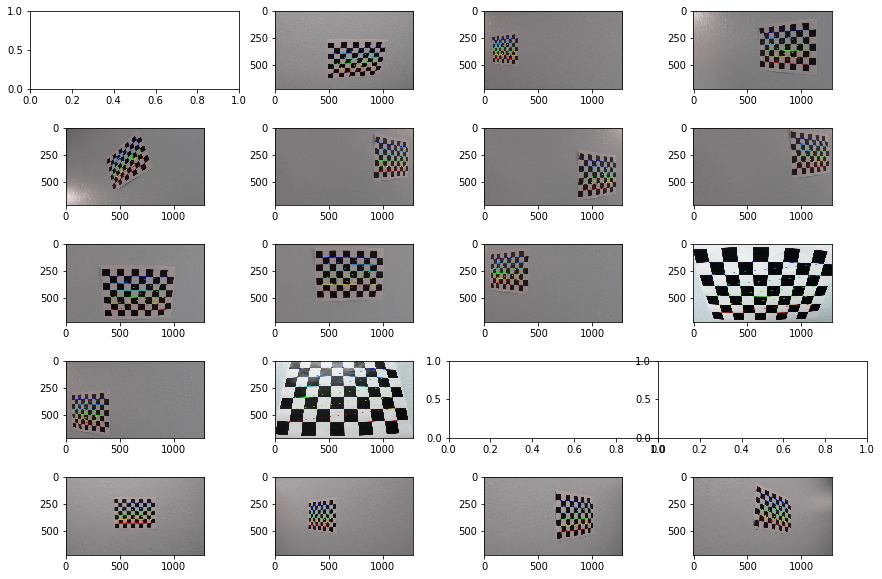

In [1]:
import numpy as np
import cv2
import glob

#import matplotlib
#matplotlib.use('Qt4Agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from IPython.core.debugger import Tracer

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
#Tracer()()

fig, axs = plt.subplots(5,4, figsize=(15,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs=axs.ravel()
# Step through the list and search for chessboard corners
for idx,fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
    #Tracer()()

     # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

         # Draw and display the corners
        img=cv2.drawChessboardCorners(img, (9,6), corners, ret)
         #cv2.imshow('img',img1)
         #cv2.waitKey(1)
        axs[idx].imshow(img)

In [2]:
def cal_undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def warp_corners(undist,gray):
    offset = 450
    img_size = (gray.shape[1], gray.shape[0])

    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], 
                                [offset, img_size[1]], 
                               [img_size[0]-offset, img_size[1]]])
    src = np.float32([[577, 463], [704, 463],[277, 670], [1029, 670]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv=cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped, M, Minv

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1 
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def r_threshold(r_channel,r_thresh):
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    return r_binary

def s_threshold(s_channel,s_thresh):
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary
    
def h_threshold(h_channel,h_thresh):
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    return h_binary

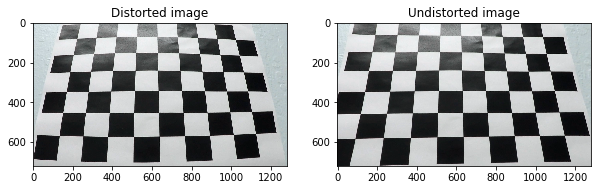

In [72]:
img1 = cv2.imread('../camera_cal/calibration3.jpg')
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img1.shape[1::-1], None, None)
undist_test = cv2.undistort(img1, mtx, dist, None, mtx)
fig, axs = plt.subplots(1,2, figsize=(10,6), facecolor='w', edgecolor='k')
axs=axs.ravel()
axs[0].imshow(img1)
axs[0].set_title('Distorted image')
axs[1].imshow(undist_test)
axs[1].set_title('Undistorted image')

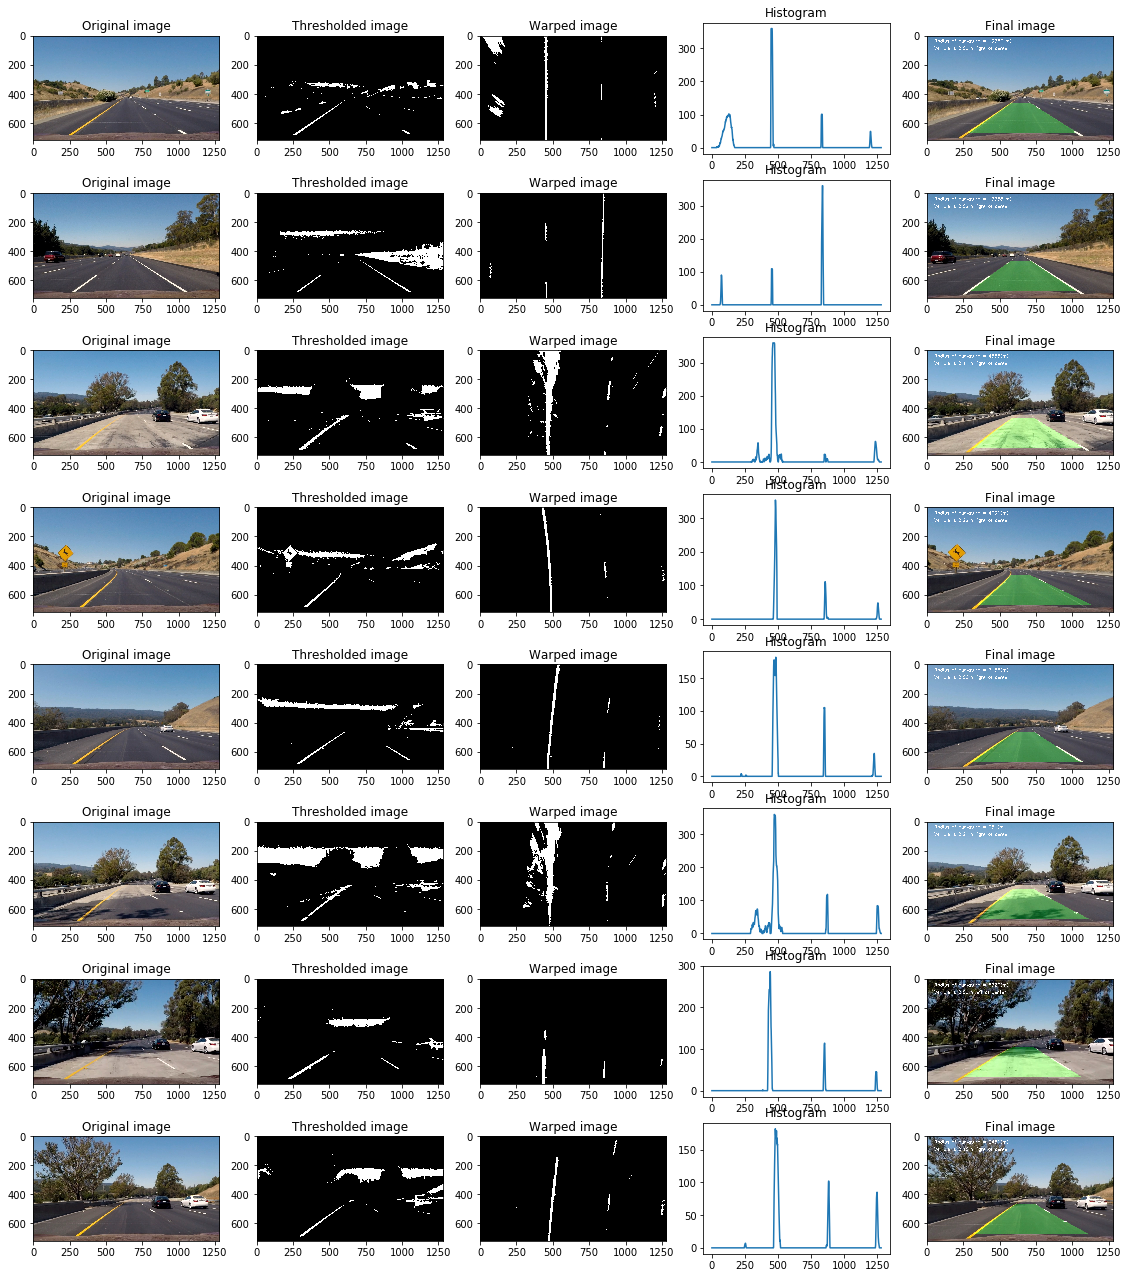

In [58]:
img1 = cv2.imread('../camera_cal/calibration11.jpg')
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img1.shape[1::-1], None, None)
count=0
images = glob.glob('../test_images/*.jpg')
#Tracer()()
fig, axs = plt.subplots(len(images),5, figsize=(15,19), facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = .5, wspace=.007)
fig.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
axs=axs.ravel()
i=0
for fname in images:
    img = cv2.imread(fname)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    comb_binary,top_down,histogram,result = pipeline(img)
    axs[i].imshow(img)
    axs[i].set_title('Original image')
    i=i+1
    axs[i].imshow(comb_binary,cmap='gray')
    axs[i].set_title('Thresholded image')
    i=i+1
    axs[i].imshow(top_down, cmap='gray')
    axs[i].set_title('Warped image')
    i=i+1
    axs[i].plot(histogram)
    axs[i].set_title('Histogram')
    i=i+1
    axs[i].imshow(result)
    axs[i].set_title('Final image')
    i=i+1

In [3]:
img1 = cv2.imread('../camera_cal/calibration11.jpg')
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img1.shape[1::-1], None, None)

In [10]:
def sliding_window_polynomial_fit(binary_warped):
    #binary_warped=top_down
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 12
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 20
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 


    # Fit a second order polynomial to each
    if len(leftx)==0:
        left_fit=[]
    else:
        left_fit = np.polyfit(lefty, leftx, 2)

    if len(rightx)==0:
        right_fit=[]
    else:        
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

(720, 0)

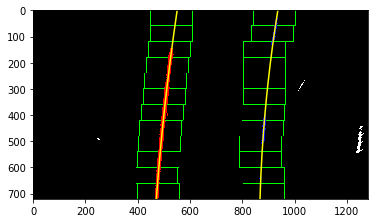

In [74]:

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [5]:
def skip_sliding_window(left_fit,right_fit,binary_warped):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    if len(leftx)==0:
        left_fit=[]
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    
    if len(rightx)==0:
        right_fit=[]
    else:        
        right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    
    return left_fit,right_fit

(720, 0)

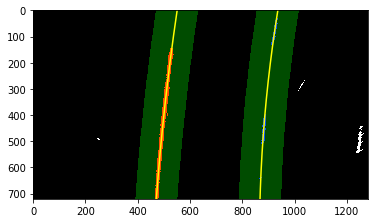

In [75]:
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(binary_warped.shape[0], 0)

In [6]:
def radius_of_curvature(left_fit,right_fit,binary_warped):
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    rad_avg=(left_curverad+right_curverad)/2
    left_bottom = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_bottom = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    lane_center_pix=(left_bottom+right_bottom)/2
    image_center_pix=640
    offset=(lane_center_pix-image_center_pix)*xm_per_pix
    
    return left_curverad,right_curverad,ploty,rad_avg,offset

#print(left_curverad)
#print(right_curverad)

In [7]:
def sanity_check(left_fit,right_fit):
    if len(left_fit)==0 or len(right_fit)==0:
        check=False
    else:
        # Calculate slope of left and right lanes at midpoint of y (i.e. 360)
        L_0 = 2*left_fit[0]*360+left_fit[1]
        R_0 = 2*right_fit[0]*360+right_fit[1]
        delta_slope_mid =  np.abs(L_0-R_0)
        
         # Calculate slope of left and right lanes at top of y (i.e. 720)
        L_1 = 2*left_fit[0]*720+left_fit[1]
        R_1 = 2*right_fit[0]*720+right_fit[1]
        delta_slope_top =  np.abs(L_1-R_1)
        #Check if lines are parallel at the middle
        
        if delta_slope_mid<=0.1:
            check = True
        else:
            check = False
    return check    

In [8]:
def pipeline(img):
    
    global prev_left_fit
    global prev_right_fit
    global cur_left_fit
    global cur_right_fit
    global count
    
    #try: 
    undist=cal_undistort(img)

    # Choose a Sobel kernel size
    ksize = 3 
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(0, 255))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(0, 255))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(0, 255))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0, np.pi/2))

    r_channel = img[:,:,0]
    g_channel = img[:,:,1]
    b_channel = img[:,:,2]
    r_binary=r_threshold(r_channel,r_thresh=(150, 255))
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    s_binary=s_threshold(s_channel,s_thresh=(80, 255))
    h_binary=h_threshold(h_channel,h_thresh=(15, 100))

    combined_binary = np.zeros_like(gradx)
    combined_binary[((s_binary == 1) & (r_binary == 1))] = 1

    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    top_down, perspective_M, Minv = warp_corners(combined_binary,gray)
    histogram = np.sum(top_down[top_down.shape[0]/2:,:], axis=0)

    if count==0:
        cur_left_fit, cur_right_fit=sliding_window_polynomial_fit(top_down)
    else:
        cur_left_fit, cur_right_fit=skip_sliding_window(cur_left_fit,cur_right_fit,top_down)
        
    flag=sanity_check(cur_left_fit,cur_right_fit)
    if flag==True:
        prev_left_fit,prev_right_fit=cur_left_fit,cur_right_fit
        count=1
    else:
        cur_left_fit, cur_right_fit=sliding_window_polynomial_fit(top_down)
        flag=sanity_check(cur_left_fit,cur_right_fit)
        if flag==True:
            prev_left_fit,prev_right_fit=cur_left_fit,cur_right_fit
            count=1
        else:
            cur_left_fit,cur_right_fit=prev_left_fit,prev_right_fit
        
    left_curved,right_curved,ploty,rad_avg,offset=radius_of_curvature(cur_left_fit,cur_right_fit,top_down)

    warp_zero = np.zeros_like(top_down).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    cur_left_fitx = cur_left_fit[0]*ploty**2 + cur_left_fit[1]*ploty + cur_left_fit[2]
    cur_right_fitx = cur_right_fit[0]*ploty**2 + cur_right_fit[1]*ploty + cur_right_fit[2]
    pts_left = np.array([np.transpose(np.vstack([cur_left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([cur_right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, 'Radius of curvature = %d(m)' % rad_avg, (50, 50), font, 1, (255, 255, 255), 2)
    left_or_right = "left" if offset < 0 else "right"
    cv2.putText(result, 'Vehicle is %.2fm %s of center' % (np.abs(offset), left_or_right), (50, 100), font, 1,
                (255, 255, 255), 2)
    #except:
     #   return img
    
    #return combined_binary, top_down, histogram, result
    return result

In [11]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

count=0
write_output = '../project_video_out_my.mp4'
clip1 = VideoFileClip("../project_video.mp4")
write_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video ../project_video_out_my.mp4
[MoviePy] Writing video ../project_video_out_my.mp4


100%|█████████████████████████████████████▉| 1260/1261 [04:51<00:00,  4.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_video_out_my.mp4 

Wall time: 4min 52s


In [12]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

count=0
write_output = '../project_video_out_harder.mp4'
clip1 = VideoFileClip("../harder_challenge_video.mp4")
write_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video ../project_video_out_harder.mp4
[MoviePy] Writing video ../project_video_out_harder.mp4


100%|█████████████████████████████████████▉| 1199/1200 [05:15<00:00,  4.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_video_out_harder.mp4 

Wall time: 5min 16s
